# Capstone Project - The Battle of Neighborhoods (Week 1-2)

## Introduction

### Background 

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014. 
While English remains the most widely spoken language, there are areas in the outer boroughs in which up to 25% of people speak English only as an alternate language. 

Indians are the largest South Asian group, comprising 2.4% of the city's population, among the largest in the US cities. New york city also sees a lot of tourists consuming at local buissness. At 65.2 million the number of tourists is many times the population of the city at 8.1 million. New york city also sees a lot of commute from outside the city. Tourists and commuters indicate that residential data alone might not be a good indicator of the consumption patterns in the city. All of these factors make New York city a unique problem for data analysis. 

Indian are highly popular in the united states. These restaurants attract a diverse set of people, and not just Indian origin people. This suggests factors other than just ethnicity of the poeple wouldn't dictate the presence of an Indian restaurant. Determining the reason for the presence of an Indian restaurant would open up data savvy entreprenuer to find neighborhoods to open an Indian restaurant.  


### Buisness Problem: Determine the variable that can predict the presence of Indian restaurants in NYC

## Data section

The data used would two sets of categories the Target and the paramters
The Target data would be the number of restaurants per NYC borough. This would be obtained from foursqaure API
The data for the parameters would be 

    1) People of Indian and other south asian countries Origin from https://www.baruch.cuny.edu/nycdata/population-geography/foreign-birthcountry.htm
    2) Buissnesses of other categories such as Chinese restaurants, Yoga studios etc from fourrsquare
    3) General population statistic data https://guides.newman.baruch.cuny.edu/nyc_data/nbhoods
        Social
        Economic
        Housing
        Demographic
The idead is to find correlation between number of indian restaurants and any of the parameters. 

Interpolation techniques would be used to find the relationship and the strength of the relationship 

### Data scraping and cleaning
Loading libraries 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

Load Neighboorhood data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

Data downloaded!


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [3]:
neighborhoods.shape

(306, 4)

Download indian population statistics

In [4]:
#data from https://www.baruch.cuny.edu/nycdata/population-geography/foreign-birthcountry.htm
popu = [2233, 9335, 15992, 48249,3387]
totPopu = [535582, 959025, 470212, 1115696, 114425]
boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

# create empty data frame in pandas
dfInds = pd.DataFrame()
dfInds['borough'] = boroughs
dfInds['population'] = popu
dfInds['totalPopulation'] = totPopu
dfInds.head()

,borough,population,totalPopulation
0,Bronx,2233,535582
1,Brooklyn,9335,959025
2,Manhattan,15992,470212
3,Queens,48249,1115696
4,Staten Island,3387,114425


Coords of every borough 

In [5]:
dfBoroughsCoords = pd.DataFrame()
dfBoroughsCoords['borough'] = boroughs
#data from https://www.latlong.net/
dfBoroughsCoords['Latitude'] = [40.837048,40.650002, 40.7188, 40.742054, 40.579021 ]
dfBoroughsCoords['Longitude'] = [- 73.865433, -73.949997, -74.0115, -73.769417, -74.151535 ]


In [6]:
# find the radius of every borough 
areas = np.array([109.04, 183.42, 59.13, 281.09, 151.18]) # convert to m 
radii = np.sqrt(areas)*1000
dfBoroughsCoords['Radii'] = radii
dfBoroughsCoords.head()

,borough,Latitude,Longitude,Radii
0,Bronx,40.837048,-73.865433,10442.221986
1,Brooklyn,40.650002,-73.949997,13543.264008
2,Manhattan,40.718800,-74.011500,7689.603371
3,Queens,40.742054,-73.769417,16765.738874
4,Staten Island,40.579021,-74.151535,12295.527642


Load foursquare

In [7]:
CLIENT_ID = '55E5TRERKKXUCBPOPEOHWXBUJ5FM1JRN1XU3WDVG1421F0FV' # your Foursquare ID
CLIENT_SECRET = 'BY3VZ1IX5M2KY2GVJ1P5C2GUOJQ20NHXS3GVSG034AIAAYHX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: 55E5TRERKKXUCBPOPEOHWXBUJ5FM1JRN1XU3WDVG1421F0FV
CLIENT_SECRET:BY3VZ1IX5M2KY2GVJ1P5C2GUOJQ20NHXS3GVSG034AIAAYHX


### Find indian restaurants in every neighborhood

plot a map of every Borough first 

In [8]:
# create map of Manhattan using latitude and longitude values
map_NYCBo = folium.Map(location=[ 40.7128, -74.0060], zoom_start=12)

# add markers to map
for lat, lng, label in zip(dfBoroughsCoords['Latitude'], dfBoroughsCoords['Longitude'], dfBoroughsCoords['borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYCBo)  
    
map_NYCBo

Plot indian in every bourough 

In [9]:
# PLot area plot
ax1 = dfInds.plot.bar(x='borough', y='population', rot=0)

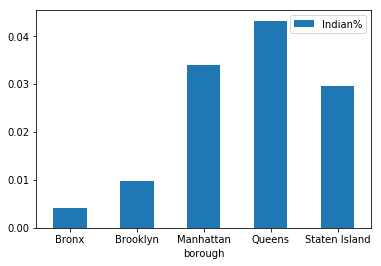

In [10]:
# Plot percentage of indians
dfInds['Indian%'] = dfInds['population']/dfInds['totalPopulation']
ax = dfInds.plot.bar(x='borough', y='Indian%', rot=0)


#### Find indian restaurant in every neighborhood

In [11]:
noOfNeighs = neighborhoods.shape[0]
Radius =2000
noOfIndRest= np.empty([noOfNeighs, 1])
for i in range(noOfNeighs): # 
    neighborhood_latitude = neighborhoods['Latitude'][i]
    neighborhood_longitude = neighborhoods['Longitude'][i]
    # category ID of indian restaurants 4bf58dd8d48988d10f941735 from https://developer.foursquare.com/docs/resources/categories
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=50&categoryId= 4bf58dd8d48988d17f941735'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        Radius)
    #url # display URL
    # del results, venues, nearby_venues
    results = requests.get(url).json()
    venues = results['response']['venues']
    nearby_venues = json_normalize(venues) # flatten JSON
    noOfIndRest[i] = nearby_venues.shape[0]
print("Extraction is done")

Extraction is done


In [12]:
#results
noOfIndRest

array([[ 0.],
       [ 3.],
       [ 2.],
       [ 0.],
       [ 2.],
       [ 3.],
       [ 2.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 3.],
       [ 5.],
       [ 0.],
       [ 1.],
       [ 4.],
       [ 5.],
       [ 4.],
       [ 2.],
       [ 6.],
       [10.],
       [ 8.],
       [ 5.],
       [ 5.],
       [ 6.],
       [ 3.],
       [ 7.],
       [ 6.],
       [ 1.],
       [ 2.],
       [ 2.],
       [ 6.],
       [ 5.],
       [ 5.],
       [ 3.],
       [ 3.],
       [ 2.],
       [ 0.],
       [ 4.],
       [ 2.],
       [ 2.],
       [ 4.],
       [ 2.],
       [ 3.],
       [ 7.],
       [ 5.],
       [ 1.],
       [ 7.],
       [ 6.],
       [ 8.],
       [22.],
       [ 5.],
       [ 5.],
       [ 3.],
       [ 8.],
       [ 9.],
       [11.],
       [ 6.],
       [ 8.],
       [ 8.],
       [25.],
       [ 3.],
       [27.],
       [18.],
       [23.],
       [31.],
       [24.],
       [19.],
       [10.],
       [19.],
       [29.],
       [23.],
      

extract a table from this result

In [13]:
neighborhoods['noOfIndian'] = noOfIndRest
neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude,noOfIndian
0,Bronx,Wakefield,40.894705,-73.847201,0.0
1,Bronx,Co-op City,40.874294,-73.829939,3.0
2,Bronx,Eastchester,40.887556,-73.827806,2.0
3,Bronx,Fieldston,40.895437,-73.905643,0.0
4,Bronx,Riverdale,40.890834,-73.912585,2.0
5,Bronx,Kingsbridge,40.881687,-73.902818,3.0
6,Manhattan,Marble Hill,40.876551,-73.910660,2.0
7,Bronx,Woodlawn,40.898273,-73.867315,0.0
8,Bronx,Norwood,40.877224,-73.879391,1.0
9,Bronx,Williamsbridge,40.881039,-73.857446,1.0


plot the locations of indian Restaurants in NYC neighborhoods 

In [41]:
# create map of Manhattan using latitude and longitude values
map_NYCNei = folium.Map(location=[ 40.7128, -74.0060], zoom_start=12)

# add markers to map
for lat, lng, label, noIndRest in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['noOfIndian']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=noIndRest,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYCNei)  
    
map_NYCNei

aggregate indian neighborhoods by borough 

In [15]:
dfBoroughsInd = neighborhoods.groupby('Borough')["noOfIndian"].sum()
dfInds['noOfIndian'] = [dfBoroughsInd[0],dfBoroughsInd[1],dfBoroughsInd[2],dfBoroughsInd[3],dfBoroughsInd[4]]
dfInds

,borough,population,totalPopulation,Indian%,noOfIndian
0,Bronx,2233,535582,0.004169,191.0
1,Brooklyn,9335,959025,0.009734,800.0
2,Manhattan,15992,470212,0.034010,1467.0
3,Queens,48249,1115696,0.043246,365.0
4,Staten Island,3387,114425,0.029600,121.0


Plot 

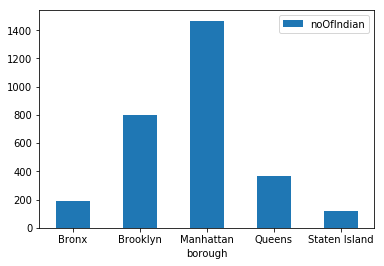

In [38]:
ax3 = dfInds.plot.bar(x='borough', y='noOfIndian', rot=0)

##### No. Of Chinese restaurants

In [39]:
noOfNeighs = neighborhoods.shape[0]
Radius =2000
noOfChinRest= np.empty([noOfNeighs, 1])
for i in range(noOfNeighs): # 
    neighborhood_latitude = neighborhoods['Latitude'][i]
    neighborhood_longitude = neighborhoods['Longitude'][i]
    # category ID of Chinese restaurants 4bf58dd8d48988d145941735 from https://developer.foursquare.com/docs/resources/categories
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=50&categoryId= 4bf58dd8d48988d145941735'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        Radius)
    #url # display URL
    # del results, venues, nearby_venues
    results = requests.get(url).json()
    venues = results['response']['venues']
    nearby_venues = json_normalize(venues) # flatten JSON
    noOfChinRest[i] = nearby_venues.shape[0]
print("Extraction is done")
neighborhoods['noOfChinese'] = noOfChinRest
neighborhoods.head(10)

Extraction is done


,Borough,Neighborhood,Latitude,Longitude,noOfIndian,noOfChinese
0,Bronx,Wakefield,40.894705,-73.847201,0.0,35.0
1,Bronx,Co-op City,40.874294,-73.829939,3.0,27.0
2,Bronx,Eastchester,40.887556,-73.827806,2.0,21.0
3,Bronx,Fieldston,40.895437,-73.905643,0.0,31.0
4,Bronx,Riverdale,40.890834,-73.912585,2.0,31.0
5,Bronx,Kingsbridge,40.881687,-73.902818,3.0,48.0
6,Manhattan,Marble Hill,40.876551,-73.910660,2.0,50.0
7,Bronx,Woodlawn,40.898273,-73.867315,0.0,35.0
8,Bronx,Norwood,40.877224,-73.879391,1.0,48.0
9,Bronx,Williamsbridge,40.881039,-73.857446,1.0,49.0


plot 

In [40]:
# create map of Manhattan using latitude and longitude values
map_NYCNei2 = folium.Map(location=[ 40.7128, -74.0060], zoom_start=12)

# add markers to map
for lat, lng, label, noOfChinese in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood'], neighborhoods['noOfChinese']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=noIndRest,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYCNei2)  
    
map_NYCNei2

### Correlation determination 

Correlation with the Indian Population 

In [32]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = dfInds['population'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = dfInds['noOfIndian'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
# Print out the statistics
print ('R2 score with population', r2_score(Y, Y_pred))


X1 = dfInds['Indian%'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = dfInds['noOfIndian'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor2 = LinearRegression()  # create object for the class
linear_regressor2.fit(X1, Y)  # perform linear regression
Y_pred2 = linear_regressor2.predict(X1)  # make predictions
# Print out the statistics
print ('R2 score with % population', r2_score(Y, Y_pred2))


R2 score with population 0.004230113856820039
R2 score with % population 0.033262213035505916


With total Indian origin people 

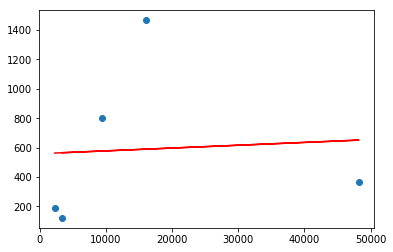

In [23]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

With Percentage of the Indian Origin People 

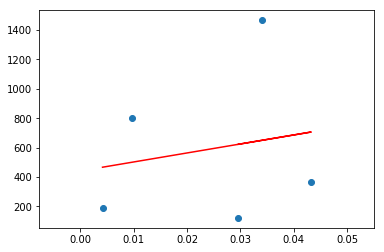

In [37]:
plt.scatter(X1, Y)
plt.plot(X1, Y_pred2, color='red')
plt.show()

Correlation with the Chinese restaurants

Filtering the neighborhoods where the search limit of 50 is reached 

In [55]:
neighborhoods2 = neighborhoods[neighborhoods['noOfChinese'] < 49]
neighborhoods3 = neighborhoods2[neighborhoods2['noOfIndian'] < 49]
neighborhoods3.shape

(202, 6)

In [58]:
X2 = neighborhoods3['noOfChinese'].values.reshape(-1, 1)  # values converts it into a numpy array
Y2 = neighborhoods3['noOfIndian'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 colum
linear_regressor3 = LinearRegression()  # create object for the class
linear_regressor3.fit(X2, Y2)  # perform linear regression
Y_pred2 = linear_regressor3.predict(X2)  # make predictions
# Print out the statistics
print ('R2 score with chinese restaurants', r2_score(Y2, Y_pred2))

R2 score with chinese restaurants 0.33520240183830496


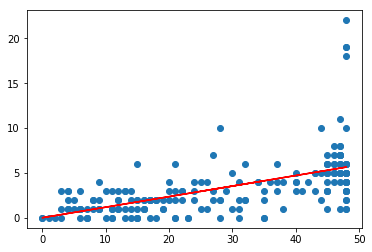

In [57]:
plt.scatter(X2, Y2)
plt.plot(X2, Y_pred2, color='red')
plt.show()

In [70]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X2)

clf = linear_model.LinearRegression()
clf.fit(X_, Y2)

Y_pred3 = clf.predict(X_)  # make predictions

print ('R2 score with ', r2_score(Y2, Y_pred3))

R2 score with  0.3574757413449964


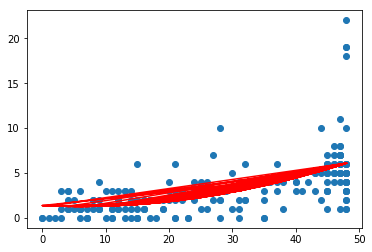

In [69]:
plt.scatter(X2, Y2)
plt.plot(X2, Y_pred3, color='red')
plt.show()

## Comclusion: Correlation with no. of Chinese restaurants is reasonable 